In [17]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
import json
import os.path
import random
import re
import time
import cv2
import requests
import pandas as pd
import progressbar
import tarfile
import zipfile
import matplotlib
import requests

from imutils import paths
from PIL import Image

from config.license_recognition import config

In [18]:
import os
import h5py


class HDF5DatasetWriter:
    def __init__(self, dims, outputPath, dataKey="images", bufSize=1000):
        # check to see if the output path exists, and if so, raise
        # an exception
        if os.path.exists(outputPath):
            raise ValueError("The supplied `outputPath` already "
                             "exists and cannot be overwritten. Manually delete "
                             "the file before continuing.", outputPath)

        outputDir = os.path.dirname(outputPath)
        if not os.path.exists(outputDir):
            os.makedirs(outputDir)

        # open the HDF5 database for writing and create two floyd:
        # one to store the images/features and another to store the
        # class labels
        self.db = h5py.File(outputPath, "w")
        self.data = self.db.create_dataset(dataKey, dims, dtype="uint8")
        self.labels = self.db.create_dataset("labels", (dims[0],), dtype=h5py.special_dtype(vlen=str))

        # store the buffer size, then initialize the buffer itself
        # along with the index into the floyd
        self.bufSize = bufSize
        self.buffer = {"data": [], "labels": []}
        self.idx = 0

    def add(self, rows, labels):
        # add the rows and labels to the buffer
        self.buffer["data"].extend(rows)
        self.buffer["labels"].extend(labels)

        # check to see if the buffer needs to be flushed to disk
        if len(self.buffer["data"]) >= self.bufSize:
            self.flush()

    def flush(self):
        # write the buffers to disk then reset the buffer
        i = self.idx + len(self.buffer["data"])
        self.data[self.idx:i] = self.buffer["data"]
        self.labels[self.idx:i] = self.buffer["labels"]
        self.idx = i
        self.buffer = {"data": [], "labels": []}

    def close(self):
        # check to see if there are any other entries in the buffer
        # that need to be flushed to disk
        if len(self.buffer["data"]) > 0:
            self.flush()

        # close the images
        self.db.close()

In [22]:
from imutils import paths

DATASET_PATH = "data/license_recognition/ilp.h5"

# read image paths and labels
paths = list(paths.list_images('images/licensePlateResized'))
labels = [p.split(os.path.sep)[-1].split(".")[0] for p in paths]


# original size of generated license plate images
IMAGE_WIDTH = 151
IMAGE_HEIGHT = 32

# create HDF5 writer
print("[INFO] building {}...".format(DATASET_PATH))
writer = HDF5DatasetWriter((len(paths), IMAGE_HEIGHT, IMAGE_WIDTH), DATASET_PATH)

# initialize the progress bar
widgets = ["Building Dataset: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval=len(paths), widgets=widgets)
pbar.start()

# loop over the image paths
for (i, (path, label)) in enumerate(zip(paths, labels)):
    # load the image and process it
    # image = cv2.imread(path, cv2.IMREAD_COLOR)  # don't use imread because bug with utf-8 paths
    stream = open(path, "rb")
    bytes = bytearray(stream.read())
    numpyarray = np.asarray(bytes, dtype=np.uint8)

    try:
        image = cv2.imdecode(numpyarray, cv2.IMREAD_GRAYSCALE)
    except:
        print("[ERROR] open image failed: %s" % path)
        continue

    # check image size
    if not image.shape == (IMAGE_HEIGHT, IMAGE_WIDTH):
        print("[ERROR] image with wrong size: %s" % path)
        continue

#     # check number length
#     if len(label) > 10:
#         print("[ERROR] image with wrong label: %s - %s" % (path, label))
#         continue

    # add the image and label # to the HDF5 images
    writer.add([image], [label])
    pbar.update(i)

# close the HDF5 writer
pbar.finish()
writer.close()

print("[INFO] {} successfully created".format(DATASET_PATH))

[INFO] building data/license_recognition/ilp.h5...
[INFO] data/license_recognition/ilp.h5 successfully created


In [11]:
import h5py
import numpy as np


class Hdf5DatasetLoader:
    def __init__(self, preprocessors=None):
        self.preprocessors = preprocessors

        # if the preprocessors are None, initialize them as an empty list
        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, db_path, shuffle=False, max_items=np.inf):

        db = h5py.File(db_path, 'r')
        images = np.array(db["images"])
        labels = np.array(db["labels"])
        db.close()

        if shuffle:
            randomized_indexes = np.arange(len(images))
            np.random.shuffle(randomized_indexes)
            images = images[randomized_indexes]
            labels = labels[randomized_indexes]

        if max_items == np.inf or max_items > len(images):
            max_items = len(images)

        images = images[0:max_items]
        labels = labels[0:max_items]

        # preprocess images
        for i, (image, label) in enumerate(zip(images, labels)):

            for p in self.preprocessors:
                image = p.preprocess(image)
                images[i] = image

        return images, labels

In [12]:
#from utils.io import Hdf5DatasetLoader

loader = Hdf5DatasetLoader()
plate_images = loader.load('data/license_recognition/ilp.h5', shuffle=True)

print ('Image count: {}'.format(len(plate_images[0])))

Image count: 595


In [20]:
def show_images(images, labels, figsize=(15, 5)):
    cols = 5
    rows = len(images) // cols

    image_index = 0
    fig, axarr = plt.subplots(rows, cols, figsize=figsize)
    for r in range(rows):
        for c in range(cols):
            image = images[image_index]
            axarr[r, c].axis("off")
            axarr[r, c].title.set_text(labels[image_index].decode())
            axarr[r, c].imshow(image)
            image_index += 1

    plt.show()

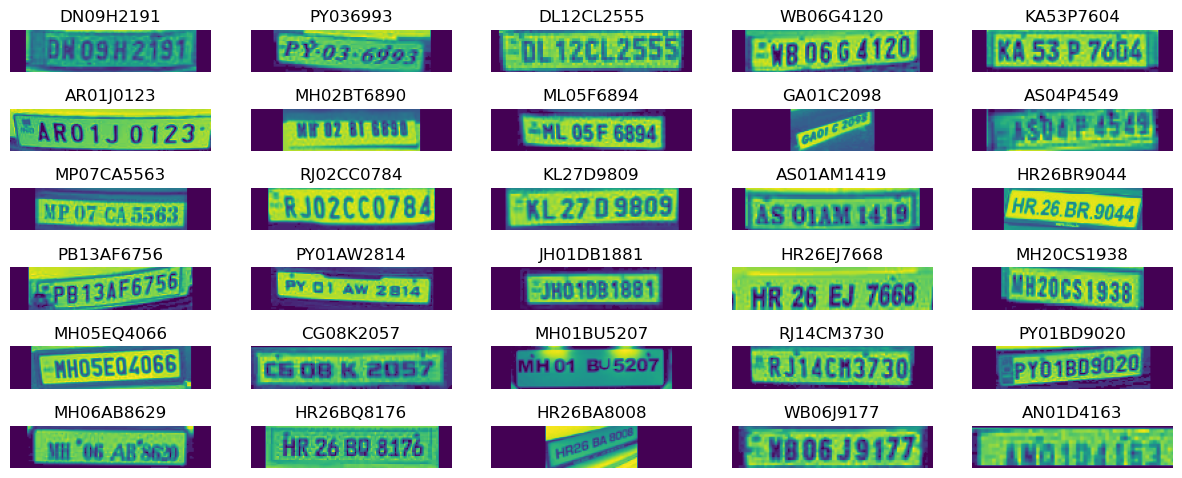

In [21]:
show_images(plate_images[0][:30], plate_images[1][:30], figsize=(15, 6))

In [15]:
loader = Hdf5DatasetLoader()
background_images = loader.load('data/license_recognition/background.h5', shuffle=True, max_items=10000)

print ('{} background images'.format(len(background_images[0])))

10000 background images


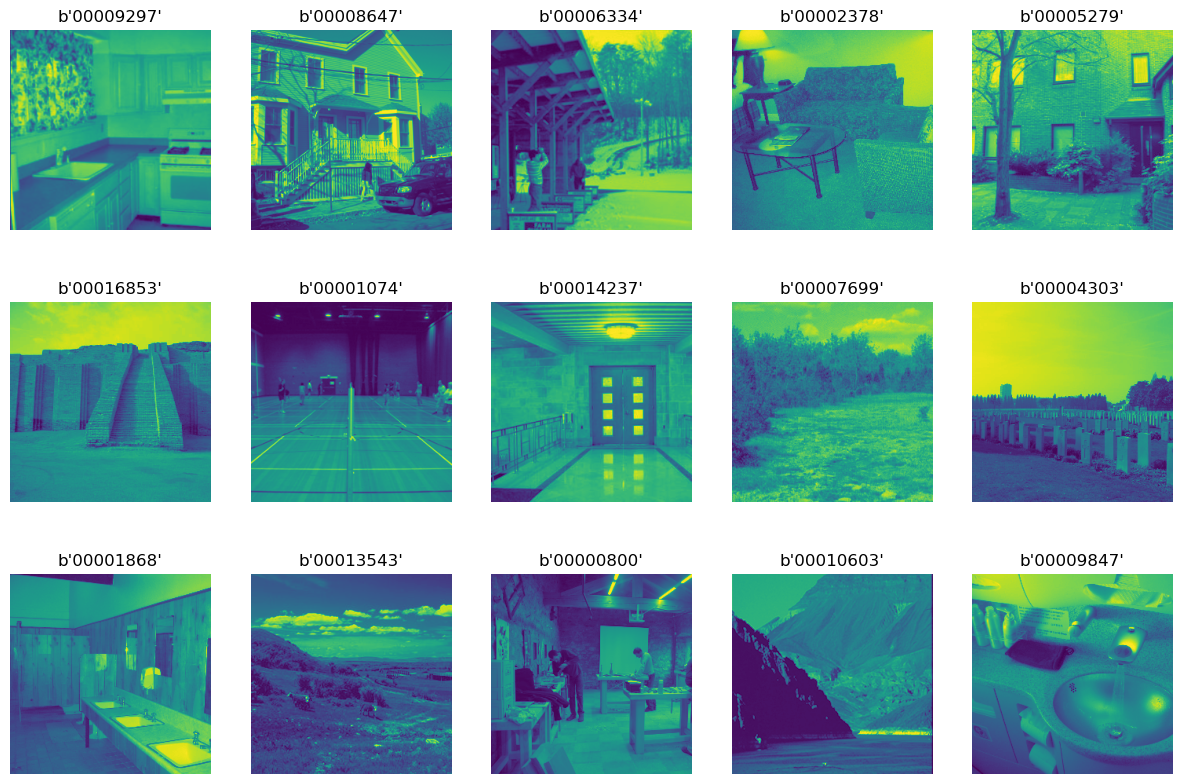

In [16]:
show_images(background_images[0][:15], background_images[1][:15], figsize=(15, 10))